### I 資料處理
1. 刪除過多缺值之欄位
2. 進行缺失值資料填補
    a. 均值插補 (mean imputation)
    b. KNN (k-nearest neighbors)
    c. 多重插補 (Multiple Imputation)
    

In [1]:
### Load EDA pkgs
import pandas as pd
import numpy as np

### Data Viz Pkgs
import matplotlib.pyplot as plt
import seaborn as sns

### Feature selection
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
## Model pkgs
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### 1. 刪除過多缺值之欄位

In [2]:
df = pd.read_csv ('../csv/MI.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,115,116,117,118,119,120,121,122,123,124
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
import pandas as pd
data =df
# 统计缺失值数量
missing=data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框
miss_analy.head(10)

,index,missNum,missRate
88,89,1696,0.997647
7,8,1628,0.957647
35,36,1076,0.632941
34,35,1076,0.632941
96,97,686,0.403529
97,98,677,0.398235
95,96,657,0.386471
84,85,375,0.220588
85,86,375,0.220588
83,84,371,0.218235


In [4]:
#先進行數據預處理將缺失嚴重與不重要的部分進行刪除column
# 统计缺失值数量
missing=df.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/df.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
miss_analy_10_limit = miss_analy[:5]
# miss_analy 存储的是每个变量缺失情况的数据框
miss_analy_10_limit = miss_analy_10_limit.set_axis(['KFK_BLOOD','IBS_NASL','D_AD_KBRIG','S_AD_KBRIG','NOT_NA_KB'], axis='index')
#miss_analy_10_limit.columns=['KFK_BLOOD','IBS_NASL','D_AD_KBRIG','S_AD_KBRIG','NOT_NA_KB','LID_KB','NA_KB','GIPER_Na']
miss_analy_10_limit.drop(labels = 'index', axis = 1, inplace=True)
miss_analy_10_limit['index'] = miss_analy_10_limit.index
miss_analy_10_limit.head()
  


,missNum,missRate,index
KFK_BLOOD,1696,0.997647,KFK_BLOOD
IBS_NASL,1628,0.957647,IBS_NASL
D_AD_KBRIG,1076,0.632941,D_AD_KBRIG
S_AD_KBRIG,1076,0.632941,S_AD_KBRIG
NOT_NA_KB,686,0.403529,NOT_NA_KB


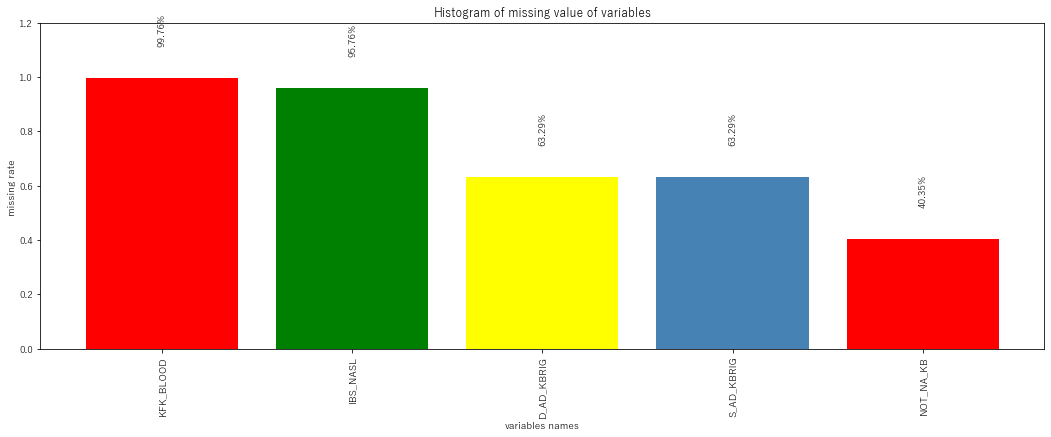

In [5]:
                           
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np

plt.rcParams['font.sans-serif']=['simhei']
plt.rcParams['font.family']='Yu Gothic' 
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(18,6))
plt.bar(np.arange(miss_analy_10_limit.shape[0]), list(miss_analy_10_limit.missRate.values), align = 'center'
    ,color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy_10_limit.shape[0]),list(miss_analy_10_limit['index']))
pl.xticks(rotation=90)
# 添加数值显示
for x,y in enumerate(list(miss_analy_10_limit.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
plt.ylim([0,1.2])
    
plt.show()

In [6]:
fig.savefig('./csv/pic/original_lostfeature.png')

In [7]:
missing=df.isnull()
corr_matrix = missing.corr()
corr_matrix

,1,2,3,4,5,6,7,8,9,10,...,115,116,117,118,119,120,121,122,123,124
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.000000,NaN,-0.003339,-0.017732,-0.014565,-0.012093,0.014461,-0.005016,-0.004728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-0.003339,NaN,1.000000,0.188325,0.229271,0.204976,0.010213,0.331070,0.351467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,-0.017732,NaN,0.188325,1.000000,0.737405,0.468053,0.030072,0.182332,0.160005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 刪除欄位，例如刪除缺失率非常高的edu變數
#
df.drop(labels = '1', axis = 1, inplace=True)
df.drop(labels = '89', axis = 1, inplace=True)
df.drop(labels = '8', axis = 1, inplace=True)
df.drop(labels = '36', axis = 1, inplace=True)
df.drop(labels = '35', axis = 1, inplace=True)
df.drop(labels = '97', axis = 1, inplace=True)
df.drop(labels = '98', axis = 1, inplace=True)
df.drop(labels = '96', axis = 1, inplace=True)

In [9]:
df.head()

,2,3,4,5,6,7,9,10,11,12,...,115,116,117,118,119,120,121,122,123,124
0,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
import pandas as pd
data =df
# 统计缺失值数量
missing=data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框
miss_analy.head(10)

,index,missNum,missRate
81,86,375,0.220588
80,85,375,0.220588
79,84,371,0.218235
78,83,369,0.217059
83,88,285,0.167647
82,87,284,0.167059
33,38,267,0.157059
32,37,267,0.157059
8,11,248,0.145882
85,91,203,0.119412


In [11]:
### I 資料處理
#1. 刪除過多缺值之欄位
df.to_csv("./csv/I-1刪除過多缺值之欄位.csv",index=0)

### 2. 進行缺失值資料填補
    a. 均值插補 (mean imputation)
    b. KNN (k-nearest neighbors)
    c. 多重插補 (Multiple Imputation)

#### 均值插補 (mean imputation)

In [12]:
df = pd.read_csv ('./csv/I-1刪除過多缺值之欄位.csv')
df.head()

,2,3,4,5,6,7,9,10,11,12,...,115,116,117,118,119,120,121,122,123,124
0,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# 替換法處理缺失值
df.fillna(value = {
    '3': df['3'].mode()[0], # 使用性別的眾數替換缺失性別
    '4': df['4'].mode()[0], # 使用性別的眾數替換缺失性別 
    '5': df['5'].mode()[0], # 使用性別的眾數替換缺失性別     
    '6': df['6'].mode()[0], # 使用性別的眾數替換缺失性別
    '7': df['7'].mode()[0], # 使用性別的眾數替換缺失性別      
    '9': df['9'].mode()[0], # 使用性別的眾數替換缺失性別
    '10': df['10'].mode()[0], # 使用性別的眾數替換缺失性別 
    '11': df['11'].mode()[0], # 使用性別的眾數替換缺失性別     
    '12': df['12'].mode()[0], # 使用性別的眾數替換缺失性別
    '13': df['13'].mode()[0], # 使用性別的眾數替換缺失性別 
    '14': df['14'].mode()[0], # 使用性別的眾數替換缺失性別   
    '15': df['15'].mode()[0], # 使用性別的眾數替換缺失性別
    '16': df['16'].mode()[0], # 使用性別的眾數替換缺失性別 
    '17': df['17'].mode()[0], # 使用性別的眾數替換缺失性別     
    '18': df['18'].mode()[0], # 使用性別的眾數替換缺失性別
    '19': df['19'].mode()[0], # 使用性別的眾數替換缺失性別 
    '20': df['20'].mode()[0], # 使用性別的眾數替換缺失性別  
    '21': df['21'].mode()[0], # 使用性別的眾數替換缺失性別     
    '22': df['22'].mode()[0], # 使用性別的眾數替換缺失性別
    '23': df['23'].mode()[0], # 使用性別的眾數替換缺失性別 
    '24': df['24'].mode()[0], # 使用性別的眾數替換缺失性別   
    '25': df['25'].mode()[0], # 使用性別的眾數替換缺失性別
    '26': df['26'].mode()[0], # 使用性別的眾數替換缺失性別 
    '27': df['27'].mode()[0], # 使用性別的眾數替換缺失性別     
    '28': df['28'].mode()[0], # 使用性別的眾數替換缺失性別
    '29': df['29'].mode()[0], # 使用性別的眾數替換缺失性別 
    '30': df['30'].mode()[0], # 使用性別的眾數替換缺失性別 
    '31': df['31'].mode()[0], # 使用性別的眾數替換缺失性別     
    '32': df['32'].mode()[0], # 使用性別的眾數替換缺失性別
    '33': df['33'].mode()[0], # 使用性別的眾數替換缺失性別 
    '34': df['34'].mode()[0], # 使用性別的眾數替換缺失性別   
    '39': df['39'].mode()[0], # 使用性別的眾數替換缺失性別 
    '40': df['40'].mode()[0], # 使用性別的眾數替換缺失性別  
    '41': df['41'].mode()[0], # 使用性別的眾數替換缺失性別     
    '42': df['42'].mode()[0], # 使用性別的眾數替換缺失性別
    '43': df['43'].mode()[0], # 使用性別的眾數替換缺失性別 
    '44': df['44'].mode()[0], # 使用性別的眾數替換缺失性別   
    '45': df['45'].mode()[0], # 使用性別的眾數替換缺失性別
    '46': df['46'].mode()[0], # 使用性別的眾數替換缺失性別 
    '47': df['47'].mode()[0], # 使用性別的眾數替換缺失性別     
    '48': df['48'].mode()[0], # 使用性別的眾數替換缺失性別
    '49': df['49'].mode()[0], # 使用性別的眾數替換缺失性別 
    '50': df['50'].mode()[0], # 使用性別的眾數替換缺失性別 
    '51': df['51'].mode()[0], # 使用性別的眾數替換缺失性別     
    '52': df['52'].mode()[0], # 使用性別的眾數替換缺失性別
    '53': df['53'].mode()[0], # 使用性別的眾數替換缺失性別 
    '54': df['54'].mode()[0], # 使用性別的眾數替換缺失性別   
    '55': df['55'].mode()[0], # 使用性別的眾數替換缺失性別
    '56': df['56'].mode()[0], # 使用性別的眾數替換缺失性別 
    '57': df['57'].mode()[0], # 使用性別的眾數替換缺失性別     
    '58': df['58'].mode()[0], # 使用性別的眾數替換缺失性別
    '59': df['59'].mode()[0], # 使用性別的眾數替換缺失性別 
    '60': df['60'].mode()[0], # 使用性別的眾數替換缺失性別  
    '61': df['61'].mode()[0], # 使用性別的眾數替換缺失性別     
    '62': df['62'].mode()[0], # 使用性別的眾數替換缺失性別
    '63': df['63'].mode()[0], # 使用性別的眾數替換缺失性別 
    '64': df['64'].mode()[0], # 使用性別的眾數替換缺失性別   
    '65': df['65'].mode()[0], # 使用性別的眾數替換缺失性別
    '66': df['66'].mode()[0], # 使用性別的眾數替換缺失性別 
    '67': df['67'].mode()[0], # 使用性別的眾數替換缺失性別     
    '68': df['68'].mode()[0], # 使用性別的眾數替換缺失性別
    '69': df['69'].mode()[0], # 使用性別的眾數替換缺失性別 
    '70': df['70'].mode()[0], # 使用性別的眾數替換缺失性別 
    '71': df['71'].mode()[0], # 使用性別的眾數替換缺失性別     
    '72': df['72'].mode()[0], # 使用性別的眾數替換缺失性別
    '73': df['73'].mode()[0], # 使用性別的眾數替換缺失性別 
    '74': df['74'].mode()[0], # 使用性別的眾數替換缺失性別   
    '75': df['75'].mode()[0], # 使用性別的眾數替換缺失性別
    '76': df['76'].mode()[0], # 使用性別的眾數替換缺失性別 
    '77': df['77'].mode()[0], # 使用性別的眾數替換缺失性別     
    '78': df['78'].mode()[0], # 使用性別的眾數替換缺失性別
    '79': df['79'].mode()[0], # 使用性別的眾數替換缺失性別 
    '80': df['80'].mode()[0], # 使用性別的眾數替換缺失性別  
    '81': df['81'].mode()[0], # 使用性別的眾數替換缺失性別     
    '82': df['82'].mode()[0], # 使用性別的眾數替換缺失性別
    '83': df['83'].mode()[0], # 使用性別的眾數替換缺失性別 
    '85': df['85'].mode()[0], # 使用性別的眾數替換缺失性別    
    '92': df['92'].mode()[0], # 使用性別的眾數替換缺失性別
    '93': df['93'].mode()[0], # 使用性別的眾數替換缺失性別 
    '94': df['94'].mode()[0], # 使用性別的眾數替換缺失性別   
    '95': df['95'].mode()[0], # 使用性別的眾數替換缺失性別
    '99': df['99'].mode()[0], # 使用性別的眾數替換缺失性別 
    '100': df['100'].mode()[0], # 使用性別的眾數替換缺失性別 
    '101': df['101'].mode()[0], # 使用性別的眾數替換缺失性別     
    '102': df['102'].mode()[0], # 使用性別的眾數替換缺失性別
    '103': df['103'].mode()[0], # 使用性別的眾數替換缺失性別 
    '104': df['104'].mode()[0], # 使用性別的眾數替換缺失性別   
    '105': df['105'].mode()[0], # 使用性別的眾數替換缺失性別
    '106': df['106'].mode()[0], # 使用性別的眾數替換缺失性別 
    '107': df['107'].mode()[0], # 使用性別的眾數替換缺失性別     
    '108': df['108'].mode()[0], # 使用性別的眾數替換缺失性別
    '109': df['109'].mode()[0], # 使用性別的眾數替換缺失性別 
    '110': df['110'].mode()[0], # 使用性別的眾數替換缺失性別  
    '111': df['111'].mode()[0], # 使用性別的眾數替換缺失性別     
    '112': df['112'].mode()[0], # 使用性別的眾數替換缺失性別
    '113': df['113'].mode()[0], # 使用性別的眾數替換缺失性別 
    '114': df['114'].mode()[0], # 使用性別的眾數替換缺失性別   
    '115': df['115'].mode()[0], # 使用性別的眾數替換缺失性別
    '116': df['116'].mode()[0], # 使用性別的眾數替換缺失性別 
    '117': df['117'].mode()[0], # 使用性別的眾數替換缺失性別     
    '118': df['118'].mode()[0], # 使用性別的眾數替換缺失性別
    '119': df['119'].mode()[0], # 使用性別的眾數替換缺失性別 
    '120': df['120'].mode()[0], # 使用性別的眾數替換缺失性別 
    '121': df['121'].mode()[0], # 使用性別的眾數替換缺失性別     
    '122': df['122'].mode()[0], # 使用性別的眾數替換缺失性別
    '123': df['123'].mode()[0], # 使用性別的眾數替換缺失性別 
    '124': df['124'].mode()[0], # 使用性別的眾數替換缺失性別   
    
    '2':df['2'].mean(), # 使用年齡的平均值替換缺失年齡
    '37':df['37'].mean(), # 使用年齡的平均值替換缺失年齡
    '38':df['38'].mean(), # 使用年齡的平均值替換缺失年齡
    '84':df['84'].mean(), # 使用年齡的平均值替換缺失年齡
    '86':df['86'].mean(), # 使用年齡的平均值替換缺失年齡
    '87':df['87'].mean(), # 使用年齡的平均值替換缺失年齡
    '88':df['88'].mean(), # 使用年齡的平均值替換缺失年齡
    '90':df['90'].mean(), # 使用年齡的平均值替換缺失年齡
    '91':df['91'].mean(), # 使用年齡的平均值替換缺失年齡       
}, inplace = True )

In [14]:
import pandas as pd
data =df
# 统计缺失值数量
missing=data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框
miss_analy.head(10)

,index,missNum,missRate


In [15]:
### I 資料處理
#1. 刪除過多缺值之欄位
df.to_csv("./csv/I-2-a-均值插補 (mean imputation).csv",index=0)

#### KNN (k-nearest neighbors)

In [16]:
df = pd.read_csv ('./csv/I-1刪除過多缺值之欄位.csv')
df.head()

,2,3,4,5,6,7,9,10,11,12,...,115,116,117,118,119,120,121,122,123,124
0,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# sklearn '>=0.22.x'
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")

data_array = imputer.fit_transform(df)

print(data_array)
data_df = pd.DataFrame(data_array,columns = df.columns)

[[77.  1.  2. ...  0.  0.  0.]
 [55.  1.  1. ...  0.  0.  0.]
 [52.  1.  0. ...  0.  0.  0.]
 ...
 [55.  1.  3. ...  1.  0.  6.]
 [79.  0.  2. ...  0.  0.  1.]
 [63.  1.  2. ...  0.  0.  1.]]


In [18]:
data_df

,2,3,4,5,6,7,9,10,11,12,...,115,116,117,118,119,120,121,122,123,124
0,77.0,1.0,2.0,1.0,1.0,2.0,3.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,60.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,77.0,0.0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1696,70.0,0.0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1697,55.0,1.0,3.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0
1698,79.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
import pandas as pd
data =data_df
# 统计缺失值数量
missing=data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框
miss_analy.head(10)

,index,missNum,missRate


In [20]:
### I 資料處理
#1. 刪除過多缺值之欄位
data_df.to_csv("./csv/I-2-b-KNN (k-nearest neighbors).csv",index=0)

#### 多重插補 (Multiple Imputation)

In [21]:
df = pd.read_csv ('./csv/I-1刪除過多缺值之欄位.csv')
df.head()

,2,3,4,5,6,7,9,10,11,12,...,115,116,117,118,119,120,121,122,123,124
0,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
import miceforest as mf
# Create kernel. 
kds = mf.KernelDataSet(
  df,
  save_all_iterations=True,
  random_state=2000
)

# Run the MICE algorithm for 3 iterations
#kds.mice(5,verbose=1)
kds.mice(5,n_jobs=7)

# Return the completed kernel data
completed_data = kds.complete_data()

In [23]:
print(kds)

              Class: KernelDataSet
         Iterations: 5
  Imputed Variables: 103
save_all_iterations: True


In [24]:
completed_data

,2,3,4,5,6,7,9,10,11,12,...,115,116,117,118,119,120,121,122,123,124
0,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,77.0,0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0,0,1,0,1,0,0,0,0,3
1696,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1697,55.0,1,3.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,6
1698,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,2.0,...,0,0,0,1,0,0,0,0,0,1


C:\Users\_\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\_\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\_\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\_\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\_\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\_\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

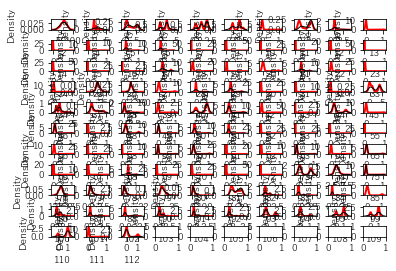

In [25]:
kds.plot_imputed_distributions(wspace=0.5,hspace=1)

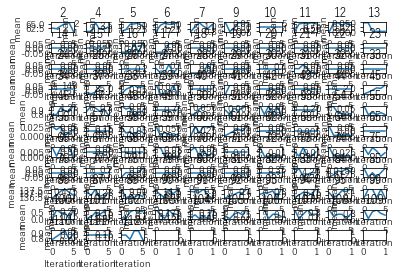

In [26]:
kds.plot_mean_convergence(wspace=0.5,hspace=1.2)

In [27]:
#df.columns=['年齡','性別','數量的心肌梗塞在病歷','病史中的勞力性心絞痛','上一年心絞痛功能等級','最近幾週（冠心病，冠心病）','存在原發性高血壓','有症狀的高血壓','動脈高血壓的持續時間','病史中存在慢性心力衰竭','觀察回憶中的心律失常','在病歷早產宮縮心房','病史中的室性早搏','病史中房顫的發作','持續形式的房顫（心房顫動）','心室顫動在病歷','病史中的室性陣發性心動過速','既往史中的一級 AV 阻滯','既往史中的三度 AV 阻滯','LBBB（前支）在病歷','病歷中的不完全','病史中的完全','不完全RBBB在病歷','在病歷（NP10）完整RBBB','糖尿病的既往病史','病史中的肥胖','甲狀腺毒症在病歷','在病歷慢性支氣管炎','在病歷31.Obstructive慢性支氣管炎','支氣管哮喘的既往史','慢性肺炎（zab_leg_04）','在既往病史（zab_leg_06）','重症監護室的收縮壓','重症監護室的舒張壓','入住重症監護病房時的肺水腫','入住重症監護病房時的心源性休克','入住重症監護病房時（或在院前階段）房顫發作 (MP_TP_POST)','入住重症監護病房時（或入院前階段）室上性心動過速的發作 (SVT_POST)','入住重症監護病房時（或在院前階段）室性心動過速的發作 (GT_POST)','心室顫動在入住重症監護病房時（或在院前階段）(FIB_G_POST)','存在前壁心肌梗塞（左心室）（V1：V4 導聯的心電圖變化）（ant_im）','存在側向心肌梗死（左心室）（ECG）導聯變化','存在下壁心肌梗死（左心室）（心電圖 III、AVF、II 導聯的變化）','存在後部心肌梗死（左心室）（V7 的心電圖變化：V9，導聯 V1 – V3 的交互變化）','右心室心肌梗塞 (IM_PG_P)','入院時的心電圖節律：竇性（心率 60-90）','ECG節律：心房纖維性顫動（ritm_ecg_p_02）','ECG節律：心房（ritm_ecg_p_04）','入院時心電圖節律：室性（ritm_ecg_p_06）','入院時心電圖節律心率高於 90 的竇（心動過速）','入院時心電圖心律：竇性心率低於 60（心動過緩','過早收縮 56入院時的心電圖 (n_r_ecg_p_01)','入院時心電圖頻繁出現房性早搏 (n_p2_g)ec','入院時心電圖上的室性早搏 (n_r_ecg_p_03)','入院時心電圖頻發室性早搏到醫院 (n_r_ecg_p_04)','入院時心電圖上的房顫發作 (n_r_5s_cg_)','入院時 ECG 上持續存在的房顫形式 (n_r_ecg_p_06)','陣發性心動過速的心室性心動過速 ECG','入院到醫院的時間（n_r_ecg_p_09）上ECG室性心動過速63發作','入院時心電圖上的心室顫動 (n_r_ecg_p_10)','入院時心電圖上的竇房阻滯 (n_p_ecg_p_01)','入院時心電圖一級房室傳導阻滯 (n_p_ecg_p_03)','1-6 度二度類型入院時心電圖顯示房室傳導阻滯（Mobitz I/Wenckebach）','入院時 (n_p_ecg_p_05) 心電圖顯示 2 型二度 AV 阻滯','入院時 ECG 上的 - 度 AV 阻滯 (n_p_ecg_p_06)','入院時 ECG 上的 LBBB（前支）到醫院 (n_p_ecg_p_07)','入院時心電圖上的 LBBB（後支）','不完全LBBB心電圖入院到醫院的時間（n_p_ecg_p_09）','入院時在 ECG 上完成 LBBB (n_p_ecg_p_10)','入院時 RBBB 不完整的 ECG醫院 (n_p_ecg_p_11)','入院時完成心電圖上的 RBBB (n_p_ecg_p_12)','溶栓治療（fibr_ter_01）','1米IU（fibr_ter_02）','溶栓治療（fibr_ter_03）','鏈蛋白酶 (fibr_ter_05) 的纖溶治療','IU溶栓治療（fibr_ter_06）','250k IU (fibr_ter_07) 的纖溶治療','纖溶治療由 1.5 breptionter_0 1.5 breptionter_0','低鉀血症 (GIPO_K)','血清鉀含量 (K_BLOOD) (mmol/L)','血清鈉增加（超過 150 mmol/L）（GIPER_Na）','血清鈉含量（Na_BLOOD）（mmol/L）','血清 AlAT 含量 (ALT_BLOOD) (IU/L)','血清 AsAT 含量 (AST_BLOOD) (IU/L)','白細胞計數（每升十億）（L_BLOOD）','ESR（紅細胞沉降率）（ROE）（Ð¼Ð¼','從CHD開始到醫院經過的時間（TIME_B_S）','入院前幾個小時疼痛復發期間（R_AB_1_n）','疼痛復發在住院期間的第二天（R_AB_2_n','第三天疼痛復發住院時間（R_AB_3_n）','ICU 中液態硝酸鹽的使用 (NITR_S)','住院最初幾個小時在 ICU 中使用阿片類藥物(NA_R_1_n)','住院第二天在 ICU 使用阿片類藥物（NA_R_2_n）','使用的阿片類藥物在醫院期間（NA_R_3_n）的第三天ICU','住院最初幾個小時在 ICU 中使用非甾體抗炎藥 (NOT_NA_1_n)','在醫院期間（NOT_NA_2_n）的第二天的ICU 104使用NSAID','住院第三天在 ICU 中使用非甾體抗炎藥（NOT_NA_3_n）','ICU 中利多卡因的使用 (LID_S_n)','在ICUβ受體阻滯劑（B_BLOK_S_n）','使用在ICU鈣通道阻滯劑（ANT_CA_S_n）','d°抗凝血劑（肝素）在ICU（GEPAR_S_n）的用途','ICU 中乙酰水楊酸的使用 (ASP_S_n)','在 ICU 中使用 Ticlid (TIKL_S_n)','在 ICU 中使用 Trental（TRENT_S_n）','心房纖顫（FIBR_PREDS）','室上速(PREDS_TAH)','室性心動過速 (JELUD_TAH)','心室顫動 (FIBR_JELUD)','三度房室傳導阻滯 (A_V_BLOK)','肺水腫 (OTEK_LANC)','心肌破裂 (RAZRIV)','德雷斯勒綜合徵（DRESSLER）','慢性心臟衰竭（ZSN）','復發的心肌梗死（REC_IM）','後梗死心絞痛 (P_IM_STEN)','致命結果']
# 刪除欄位，例如刪除缺失率非常高的edu變數
#
list_2 = df['2']
list_86 = df['86']
list_85 = df['85']
list_84 = df['84']
list_88 = df['88']
list_124 = df['124']
mice_list = pd.DataFrame(list(zip(list_2,list_86,list_85,list_84,list_88,list_124)), columns =['2', '86', '85', '84', '88', '124'])

In [28]:
# Create kernel. 
kernel = mf.MultipleImputedKernel(
  mice_list,
  datasets=4,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3)

In [29]:
completed_data_kernel = kernel.complete_data(3)
completed_data_kernel

,2,86,85,84,88,124
0,77.0,138.0,0.0,4.7,0.15,0
1,55.0,132.0,0.0,3.5,0.18,0
2,52.0,132.0,0.0,4.0,0.11,0
3,68.0,146.0,0.0,3.9,0.37,0
4,60.0,132.0,0.0,3.5,0.22,0
...,...,...,...,...,...,...
1695,77.0,130.0,0.0,3.7,0.52,3
1696,70.0,140.0,0.0,3.5,0.67,1
1697,55.0,136.0,0.0,5.1,0.15,6
1698,79.0,136.0,0.0,3.1,0.45,1


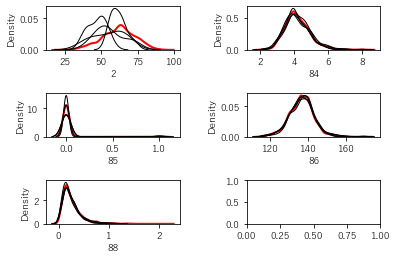

In [30]:
kernel.plot_imputed_distributions(wspace=0.5,hspace=1)

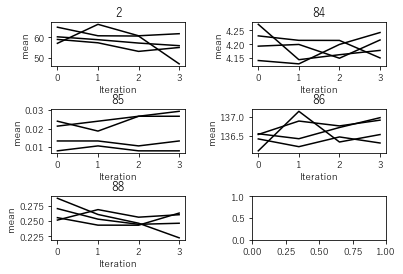

In [31]:
kernel.plot_mean_convergence(wspace=0.5,hspace=1)

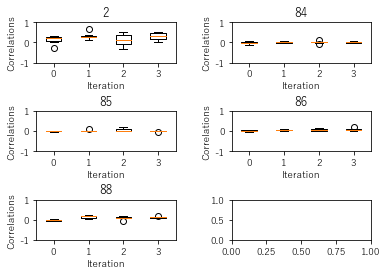

In [32]:
kernel.plot_correlations(wspace=0.4,hspace=1.2)

AxesSubplot(0.125,0.125;0.62x0.755)


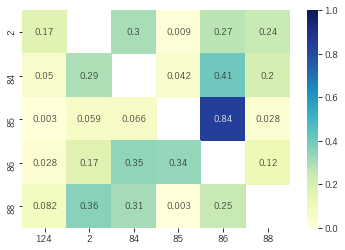

In [33]:
kernel.plot_feature_importance(annot=True,cmap="YlGnBu",vmin=0, vmax=1)

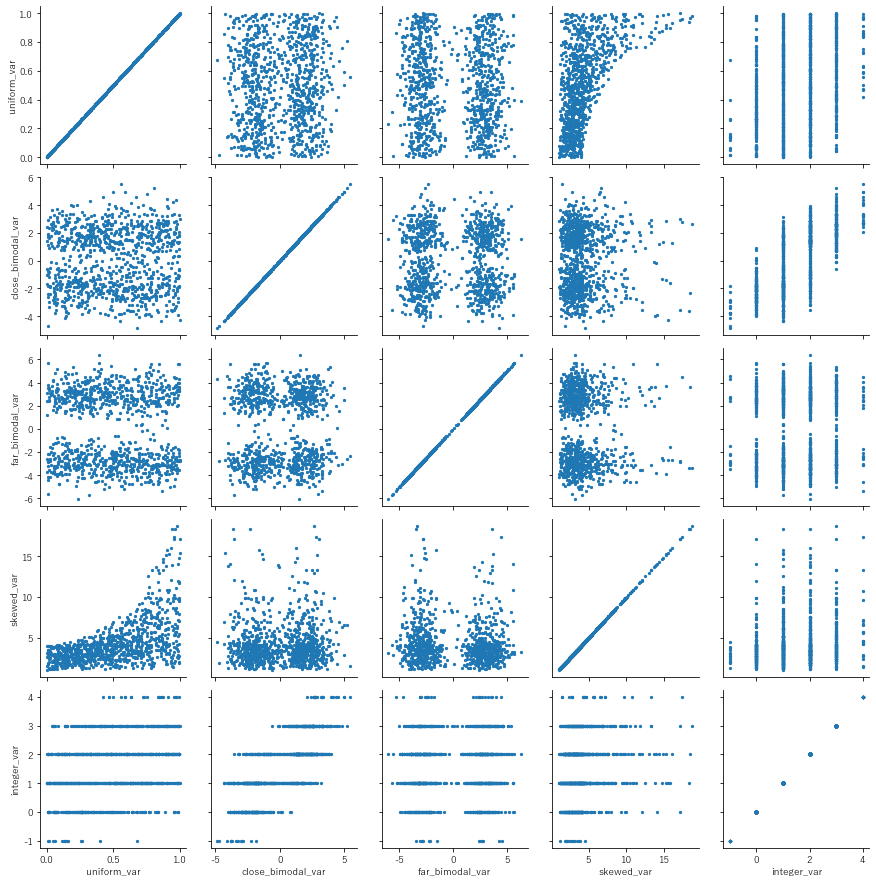

In [34]:
randst = np.random.RandomState(1991)
# random uniform variable
nrws = 1000
uniform_vec = randst.uniform(size=nrws)

def make_bimodal(mean1,mean2,size):
    bimodal_1 = randst.normal(size=nrws, loc=mean1)
    bimodal_2 = randst.normal(size=nrws, loc=mean2)
    bimdvec = []
    for i in range(size):
        bimdvec.append(randst.choice([bimodal_1[i], bimodal_2[i]]))
    return np.array(bimdvec)

# Make 2 Bimodal Variables
close_bimodal_vec = make_bimodal(2,-2,nrws)
far_bimodal_vec = make_bimodal(3,-3,nrws)

# Highly skewed variable correlated with Uniform_Variable
skewed_vec = np.exp(uniform_vec*randst.uniform(size=nrws)*3) + randst.uniform(size=nrws)*3

# Integer variable correlated with Close_Bimodal_Variable and Uniform_Variable
integer_vec = np.round(uniform_vec + close_bimodal_vec/3 + randst.uniform(size=nrws)*2)

# Make a DataFrame
dat = pd.DataFrame(
    {
    'uniform_var':uniform_vec,
    'close_bimodal_var':close_bimodal_vec,
    'far_bimodal_var':far_bimodal_vec,
    'skewed_var':skewed_vec,
    'integer_var':integer_vec
    }
)

# Ampute the data.
ampdat = mf.ampute_data(dat,perc=0.25,random_state=randst)

# Plot the original data
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(dat)
g.map(plt.scatter,s=5)

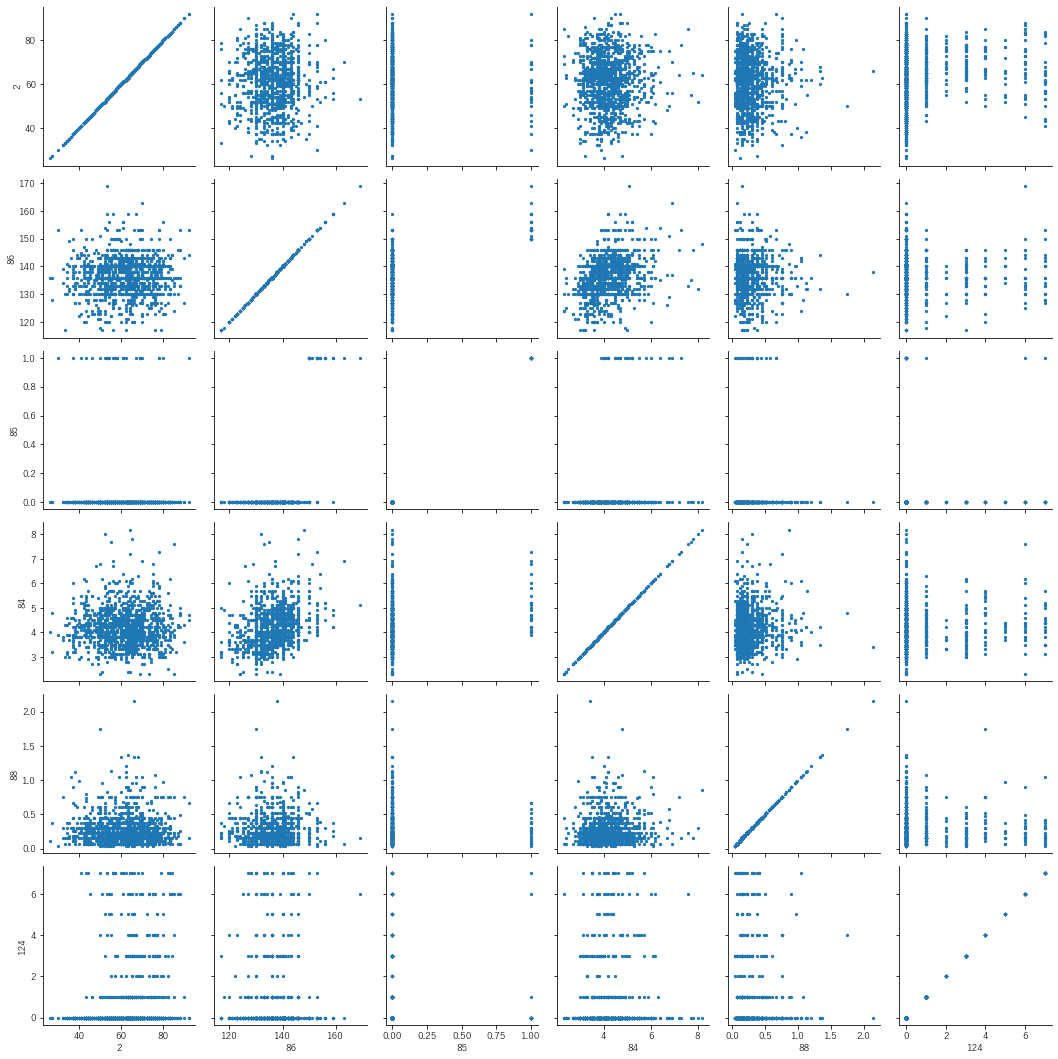

In [35]:
# Plot the original data
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(mice_list)
g.map(plt.scatter,s=5)

In [36]:
import pandas as pd
data =completed_data
# 统计缺失值数量
missing=data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框
miss_analy.head(10)

,index,missNum,missRate


In [37]:
### I 資料處理
#1. 刪除過多缺值之欄位
completed_data.to_csv("./csv/I-2-c-多重插補 (Multiple Imputation).csv",index=0)